# Insurance Agent Segmentation and Modeling Pipeline
This notebook performs feature engineering, K-Means clustering, Random Forest classification to segment and target insurance agents.

### About Dataset
An insurance group consists of 10 property and casualty insurance, life insurance and insurance brokerage companies. The property and casualty companies in the group operate in a 17-state region. The group is a major regional property and casualty insurer, represented by more than 4,000 independent agents who live and work in local communities through a six-state region. Define the metrics to analyse agent performance based on several attributes like demography, products sold, new business, etc. The goal is to improve their existing knowledge used for agent segmentation in a supervised predictive framework.

Data courtesy of Kaggle: https://www.kaggle.com/datasets/moneystore/agencyperformance

In [ ]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, accuracy_score, classification_report, davies_bouldin_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

## Part 1: EDA and Cleaning

### Import and Validation

In [4]:
df = pd.read_csv(r"C:\Users\maxwell.bicking\data-science-portfolio\Insurance Agent Classification\finalapi.csv")

In [5]:
df.head(10)

,AGENCY_ID,PRIMARY_AGENCY_ID,PROD_ABBR,PROD_LINE,STATE_ABBR,STAT_PROFILE_DATE_YEAR,RETENTION_POLY_QTY,POLY_INFORCE_QTY,PREV_POLY_INFORCE_QTY,NB_WRTN_PREM_AMT,...,PL_BOUND_CT_ELINKS,PL_QUO_CT_ELINKS,PL_BOUND_CT_PLRANK,PL_QUO_CT_PLRANK,PL_BOUND_CT_eQTte,PL_QUO_CT_eQTte,PL_BOUND_CT_APPLIED,PL_QUO_CT_APPLIED,PL_BOUND_CT_TRANSACTNOW,PL_QUO_CT_TRANSACTNOW
0,3,3,BOILERMACH,CL,IN,2005,0,0,0,40.0,...,0,0,0,103,50,288,0,0,0,0
1,3,3,BOILERMACH,CL,IN,2006,0,0,0,151.0,...,0,0,0,103,50,288,0,0,0,0
2,3,3,BOILERMACH,CL,IN,2007,0,0,0,40.0,...,0,0,0,103,50,288,0,0,0,0
3,3,3,BOILERMACH,CL,IN,2008,0,0,0,69.0,...,0,0,0,103,50,288,0,0,0,0
4,3,3,BOILERMACH,CL,IN,2009,0,0,0,28.0,...,0,0,0,103,50,288,0,0,0,0
5,3,3,BOILERMACH,CL,IN,2010,0,0,0,120.0,...,0,0,0,103,50,288,0,0,0,0
6,3,3,BOILERMACH,CL,IN,2011,0,0,0,231.0,...,0,0,0,103,50,288,0,0,0,0
7,3,3,BOILERMACH,CL,IN,2012,0,0,0,0.0,...,0,0,0,103,50,288,0,0,0,0
8,3,3,BOILERMACH,CL,IN,2013,0,0,0,111.0,...,0,0,0,103,50,288,0,0,0,0
9,3,3,BOILERMACH,CL,IN,2014,0,0,0,213.0,...,0,0,0,103,50,288,0,0,0,0


### Cleaning

In [6]:
#Selecting metrics that are key to performance
selected_numeric_cols = ['RETENTION_RATIO', 'LOSS_RATIO', 'LOSS_RATIO_3YR', 'GROWTH_RATE_3YR', 'NB_WRTN_PREM_AMT']

#Sample of key categorical columns.
selected_categorical_cols = ['PROD_ABBR', 'PROD_LINE', 'STATE_ABBR', 'VENDOR_IND', 'VENDOR']

In [7]:
df[selected_numeric_cols].describe()

,RETENTION_RATIO,LOSS_RATIO,LOSS_RATIO_3YR,GROWTH_RATE_3YR,NB_WRTN_PREM_AMT
count,213328.000000,213328.000000,213328.000000,213328.000000,213328.000000
mean,60928.406019,24926.569482,23024.118682,42688.285812,2243.651368
std,48790.262492,43257.880847,42098.349517,49462.194579,9976.801667
min,0.000000,-756.228571,-7215.007215,-1.000000,0.000000
25%,0.919540,0.000000,0.271818,-0.038417,0.000000
50%,99999.000000,0.000000,0.543219,0.141791,0.000000
75%,99999.000000,85.958571,2.726085,99999.000000,485.000000
max,99999.000000,99999.000000,99999.000000,99999.000000,556930.220000


In [8]:
#Count how many are > 10
high_loss_count = (df["LOSS_RATIO"] > 10).sum() #use 10 as outlier cutoff

#Count how many are < 0
negative_loss_count = (df["LOSS_RATIO"] < 0).sum() #we'll drop any negatives

null_loss_count = df["LOSS_RATIO"].isna().sum()

#Display both
print(f"LOSS_RATIO > 10: {high_loss_count}")
print(f"LOSS_RATIO < 0: {negative_loss_count}")
print(f"Nulls: {null_loss_count}")

LOSS_RATIO > 10: 54478
LOSS_RATIO < 0: 6009
Nulls: 0


There are many erroneous or null values coded as extremely high values (99999, 99998, etc.). We will clean and filter our data of obvious errors and extreme outliers before exploring in greater depth.

Fill Errors and Filter Outliers

In [9]:
#Clean by replacing coded nulls and filter out extreme outliers/errors

df.replace(99999, np.nan, inplace = True)
df.replace(999999, np.nan, inplace = True)

cols_to_clean = ["LOSS_RATIO", "LOSS_RATIO_3YR", "RETENTION_RATIO", "GROWTH_RATE_3YR"]
df[cols_to_clean] = df[cols_to_clean].replace([99995, 99996, 99997, 99998], np.nan)

#first add flag for missing retention ratio 
#add flag column for RETENTION_RATIO missing
df["RETENTION_RATIO_MISSING"] = df["RETENTION_RATIO"].isna().astype(int)

#next, drop bad loss ratio data
df = df[(df["LOSS_RATIO"] >= 0) & (df["LOSS_RATIO"] <= 10)]

df = df[(df["LOSS_RATIO_3YR"] >= 0) & (df["LOSS_RATIO_3YR"] <= 10)]

Fill Nulls

In [10]:
quote_systems_cols = [
    "CL_BOUND_CT_MDS", "CL_QUO_CT_MDS",
    "CL_BOUND_CT_SBZ", "CL_QUO_CT_SBZ",
    "CL_BOUND_CT_eQT", "CL_QUO_CT_eQT",
    "PL_BOUND_CT_ELINKS", "PL_QUO_CT_ELINKS",
    "PL_BOUND_CT_PLRANK", "PL_QUO_CT_PLRANK",
    "PL_BOUND_CT_eQTte", "PL_QUO_CT_eQTte",
    "PL_BOUND_CT_APPLIED", "PL_QUO_CT_APPLIED",
    "PL_BOUND_CT_TRANSACTNOW", "PL_QUO_CT_TRANSACTNOW"
]

premium_cols = [
    "NB_WRTN_PREM_AMT", 
    "PRD_ERND_PREM_AMT",
    "WRTN_PREM_AMT",
    "LOSS_RATIO_3YR", 
    "GROWTH_RATE_3YR"
]

misc_cols = [
    "MAX_AGE",
    "MIN_AGE",
    "ACTIVE_PRODUCERS"
]

fill_cols = quote_systems_cols + premium_cols + misc_cols

df[fill_cols] = df[fill_cols].fillna(0)


#special cases
df["LOSS_RATIO"] = df["LOSS_RATIO"].fillna(0) #assume NaN means 0 losses, so fill with 0

retention_median = df["RETENTION_RATIO"].median()
df["RETENTION_RATIO"] = df["RETENTION_RATIO"].fillna(retention_median) #fill retention ratio nulls with median

df["AGENCY_APPOINTMENT_YEAR"].fillna(df["STAT_PROFILE_DATE_YEAR"], inplace=True) #assume tenure is same year 

C:\Users\maxwell.bicking\AppData\Local\Temp\ipykernel_9460\1836673293.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["AGENCY_APPOINTMENT_YEAR"].fillna(df["STAT_PROFILE_DATE_YEAR"], inplace=True) #assume tenure is same year


In [11]:
df[selected_numeric_cols].describe()

,RETENTION_RATIO,LOSS_RATIO,LOSS_RATIO_3YR,GROWTH_RATE_3YR,NB_WRTN_PREM_AMT
count,122962.000000,122962.000000,122962.000000,122962.000000,122962.000000
mean,0.871659,0.286342,0.550224,0.023248,3110.223297
std,0.119142,0.868282,0.657268,0.264817,12025.823222
min,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,0.889718,0.000000,0.232668,-0.051097,0.000000
50%,0.889718,0.000000,0.429887,0.000000,0.000000
75%,0.889718,0.160342,0.655998,0.027640,1118.950000
max,1.000000,9.999835,9.979584,5.188618,556930.220000


### Exploratory Analysis

In [ ]:
#Set a consistent visualization style.
sns.set(style="whitegrid")

In [ ]:
#--- Basic Data Overview ---
print("DataFrame shape:", df.shape)
print("First 5 rows:\n", df.head())
print("\nSummary statistics:\n", df.describe())

DataFrame shape: (122962, 50)
First 5 rows:
    AGENCY_ID  PRIMARY_AGENCY_ID   PROD_ABBR PROD_LINE STATE_ABBR  \
1          3                3.0  BOILERMACH        CL         IN   
2          3                3.0  BOILERMACH        CL         IN   
3          3                3.0  BOILERMACH        CL         IN   
4          3                3.0  BOILERMACH        CL         IN   
5          3                3.0  BOILERMACH        CL         IN   

   STAT_PROFILE_DATE_YEAR  RETENTION_POLY_QTY  POLY_INFORCE_QTY  \
1                    2006                   0                 0   
2                    2007                   0                 0   
3                    2008                   0                 0   
4                    2009                   0                 0   
5                    2010                   0                 0   

   PREV_POLY_INFORCE_QTY  NB_WRTN_PREM_AMT  ...  PL_QUO_CT_ELINKS  \
1                    0.0             151.0  ...               0.0   
2    

In [ ]:
#--- Missing Values ---
missing = df.isnull().sum()
print("\nColumns with missing values:")
print(missing[missing > 0])


Columns with missing values:
PRIMARY_AGENCY_ID             14239
PREV_POLY_INFORCE_QTY          5837
PREV_WRTN_PREM_AMT             5837
PL_START_YEAR                 41341
PL_END_YEAR                  120280
COMMISIONS_START_YEAR         79020
COMMISIONS_END_YEAR          118036
CL_START_YEAR                 70234
CL_END_YEAR                  117713
ACTIVITY_NOTES_START_YEAR     97224
ACTIVITY_NOTES_END_YEAR      120509
dtype: int64


In [12]:
#--- Identify Numeric and Categorical Columns ---
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['AGENCY_ID', 'PRIMARY_AGENCY_ID', 'STAT_PROFILE_DATE_YEAR', 'RETENTION_POLY_QTY', 'POLY_INFORCE_QTY', 'PREV_POLY_INFORCE_QTY', 'NB_WRTN_PREM_AMT', 'WRTN_PREM_AMT', 'PREV_WRTN_PREM_AMT', 'PRD_ERND_PREM_AMT', 'PRD_INCRD_LOSSES_AMT', 'MONTHS', 'RETENTION_RATIO', 'LOSS_RATIO', 'LOSS_RATIO_3YR', 'GROWTH_RATE_3YR', 'AGENCY_APPOINTMENT_YEAR', 'ACTIVE_PRODUCERS', 'MAX_AGE', 'MIN_AGE', 'PL_START_YEAR', 'PL_END_YEAR', 'COMMISIONS_START_YEAR', 'COMMISIONS_END_YEAR', 'CL_START_YEAR', 'CL_END_YEAR', 'ACTIVITY_NOTES_START_YEAR', 'ACTIVITY_NOTES_END_YEAR', 'CL_BOUND_CT_MDS', 'CL_QUO_CT_MDS', 'CL_BOUND_CT_SBZ', 'CL_QUO_CT_SBZ', 'CL_BOUND_CT_eQT', 'CL_QUO_CT_eQT', 'PL_BOUND_CT_ELINKS', 'PL_QUO_CT_ELINKS', 'PL_BOUND_CT_PLRANK', 'PL_QUO_CT_PLRANK', 'PL_BOUND_CT_eQTte', 'PL_QUO_CT_eQTte', 'PL_BOUND_CT_APPLIED', 'PL_QUO_CT_APPLIED', 'PL_BOUND_CT_TRANSACTNOW', 'PL_QUO_CT_TRANSACTNOW', 'RETENTION_RATIO_MISSING']
Categorical columns: ['PROD_ABBR', 'PROD_LINE', 'STATE_ABBR', 'VENDOR_IND', 'V

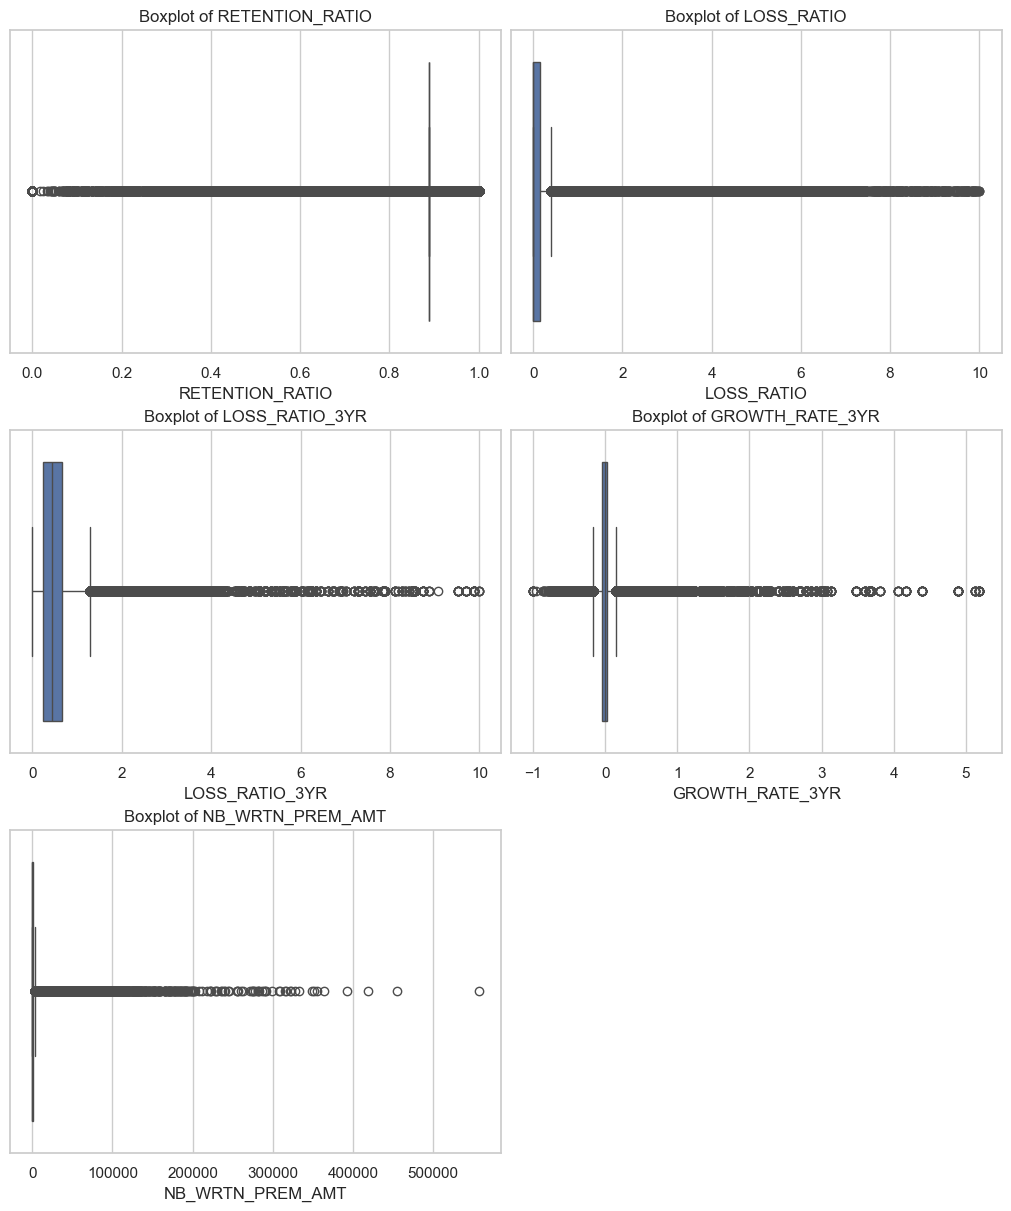

In [ ]:
#--- Boxplots for Detecting Outliers ---

n_cols = 2
n_rows = math.ceil(len(selected_numeric_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows), constrained_layout=True)
axes = axes.flatten()  # Flatten the grid to iterate easily

#Loop through each feature and plot the boxplot
for i, col in enumerate(selected_numeric_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")
    axes[i].set_xlabel(col)

#Remove any unused subplots if the grid has extra axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

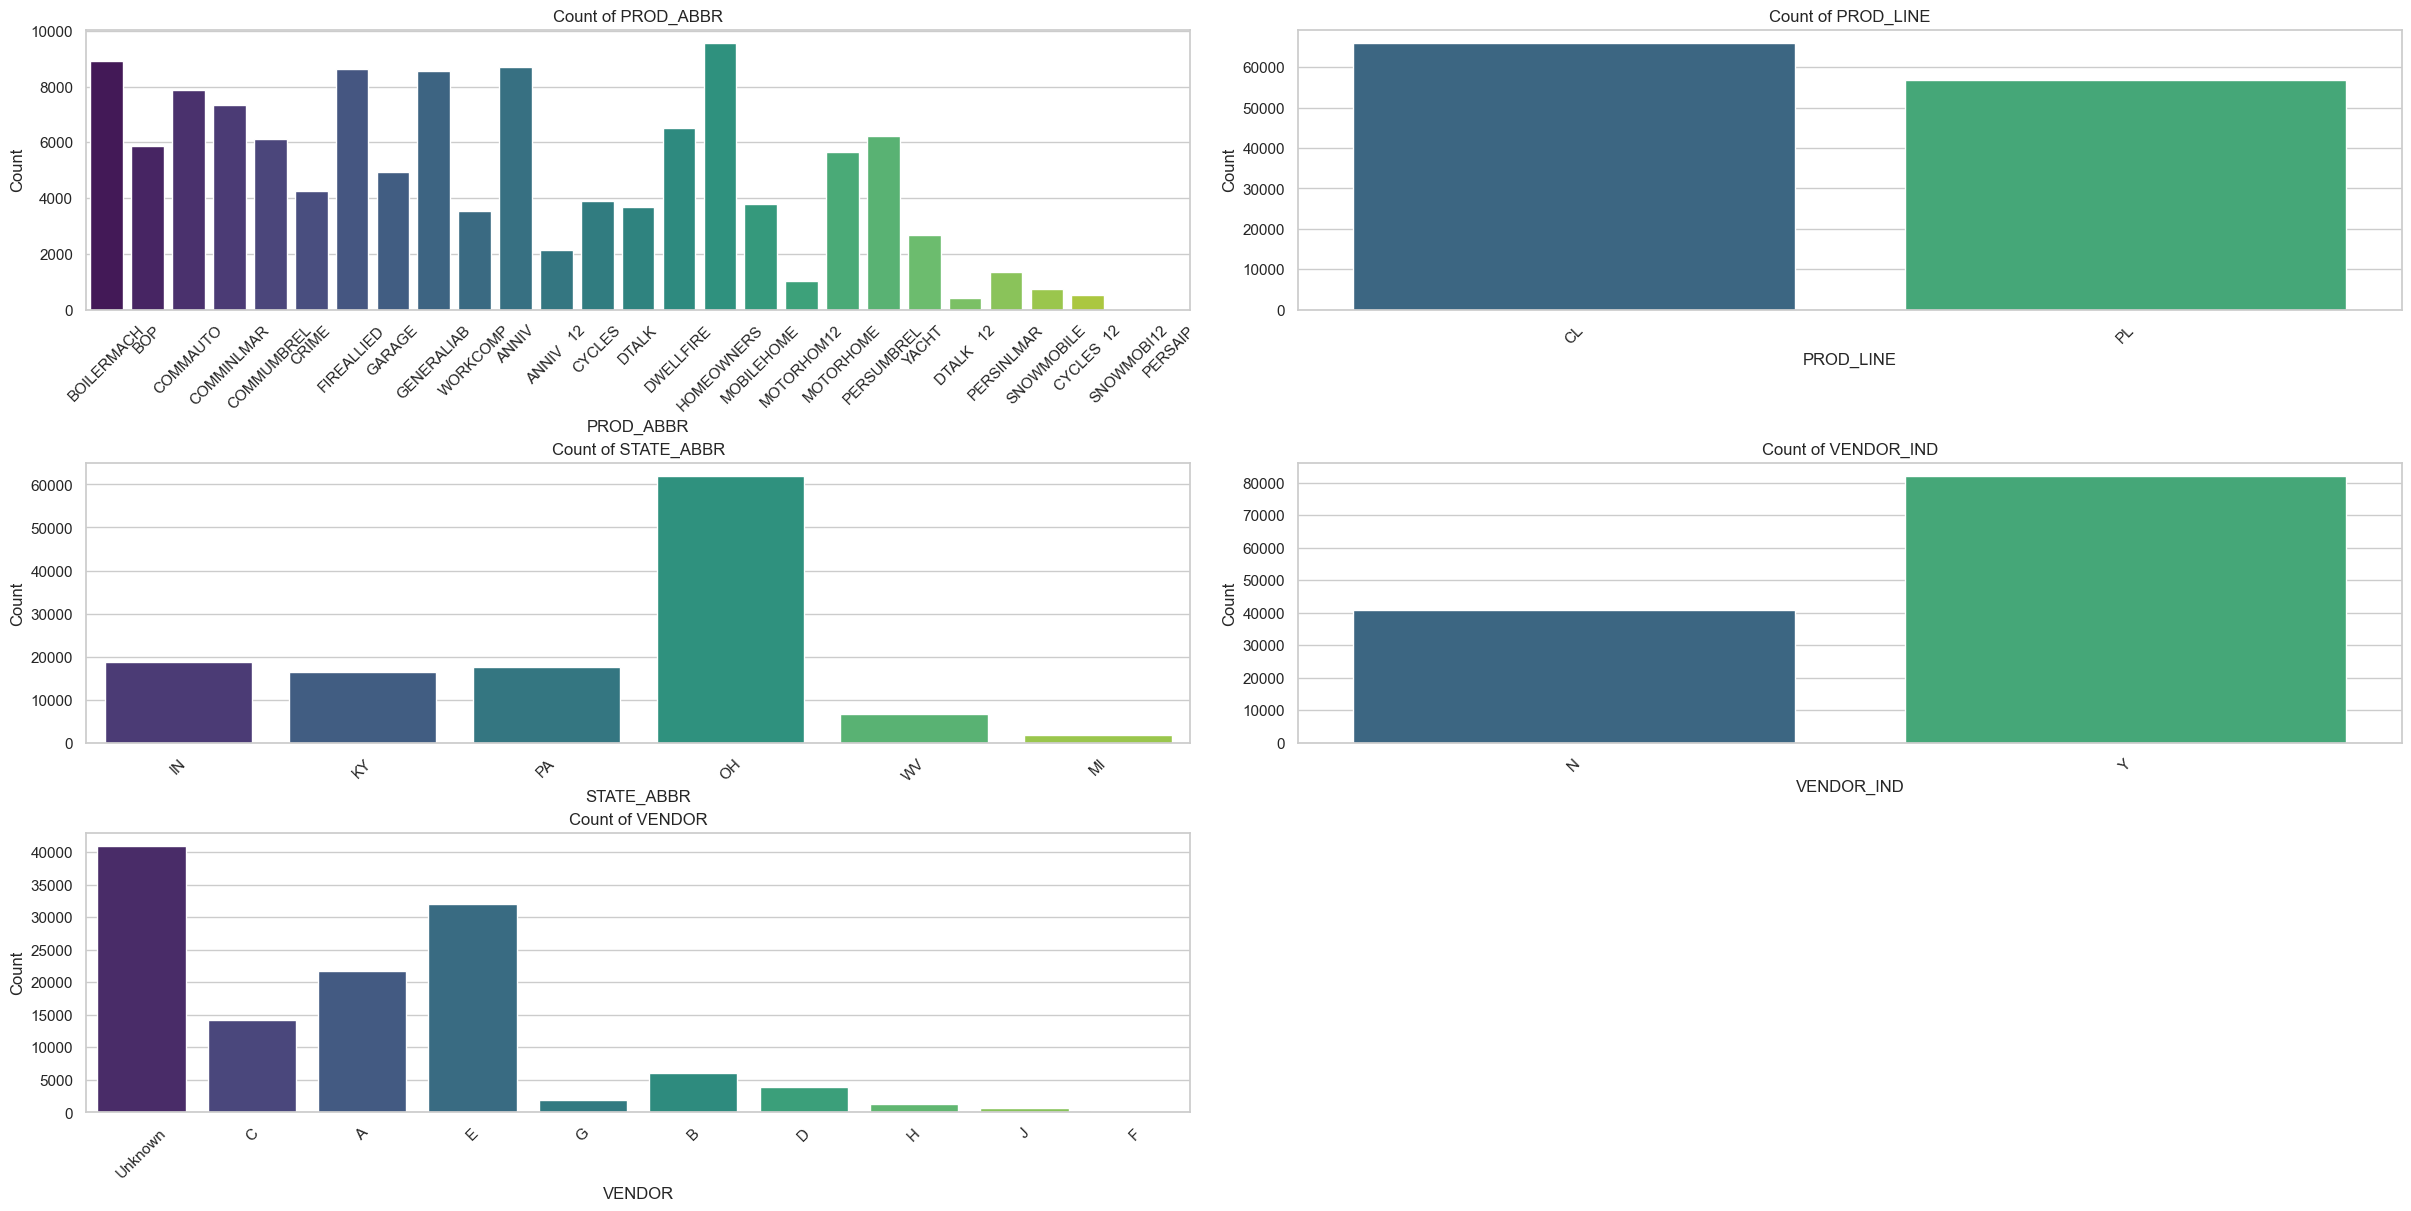

In [ ]:
#--- Analysis of Categorical Variables ---

n_cols = 2
n_rows = math.ceil(len(selected_categorical_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 4 * n_rows), constrained_layout=True)
axes = axes.flatten()

#Loop through each categorical column to create count plots
for i, col in enumerate(selected_categorical_cols):
    sns.countplot(data=df, x=col, hue = col, palette='viridis', ax=axes[i])
    axes[i].set_title(f"Count of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

#Remove any unused subplots if the grid has extra axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

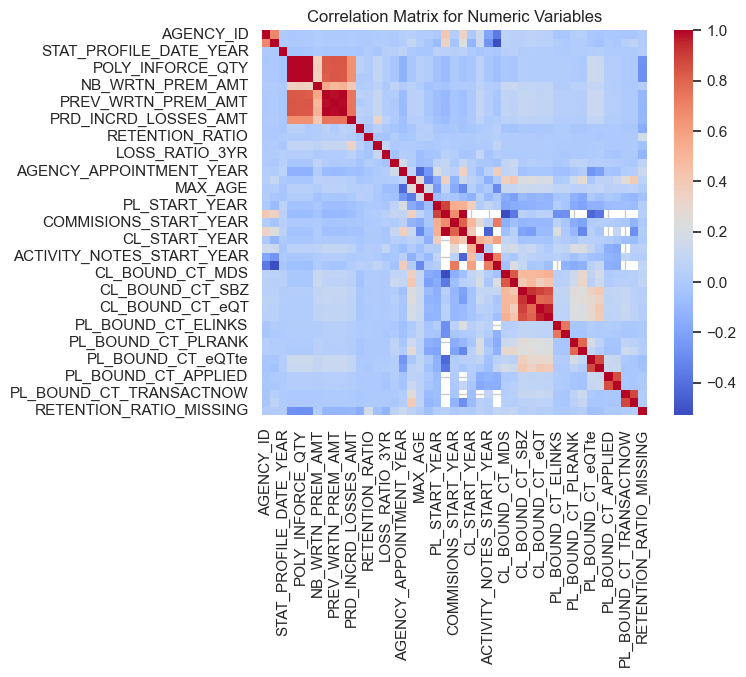

In [ ]:
#--- Correlation Matrix for Numeric Variables ---
plt.figure(figsize=(7, 5))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', square=True)
plt.title("Correlation Matrix for Numeric Variables")
plt.show()

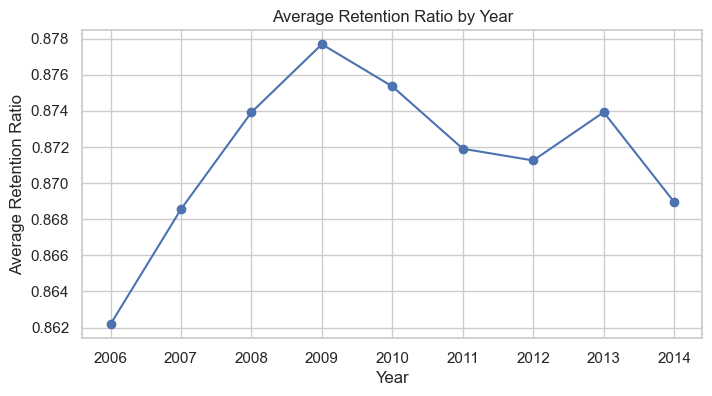

In [ ]:
#--- Time Trend Analysis ---
if 'STAT_PROFILE_DATE_YEAR' in df.columns:
    trend = df.groupby('STAT_PROFILE_DATE_YEAR')['RETENTION_RATIO'].mean()
    plt.figure(figsize=(8, 4))
    trend.plot(marker='o')
    plt.title("Average Retention Ratio by Year")
    plt.xlabel("Year")
    plt.ylabel("Average Retention Ratio")
    plt.show()


Average metrics by state:
   STATE_ABBR  RETENTION_RATIO  LOSS_RATIO  GROWTH_RATE_3YR
0         MI         0.889718    0.228019         0.138348
1         PA         0.882622    0.283384         0.046835
2         WV         0.878593    0.238363         0.045286
3         KY         0.871531    0.306312         0.041077
4         OH         0.870133    0.283141         0.007963
5         IN         0.862436    0.304731         0.017633


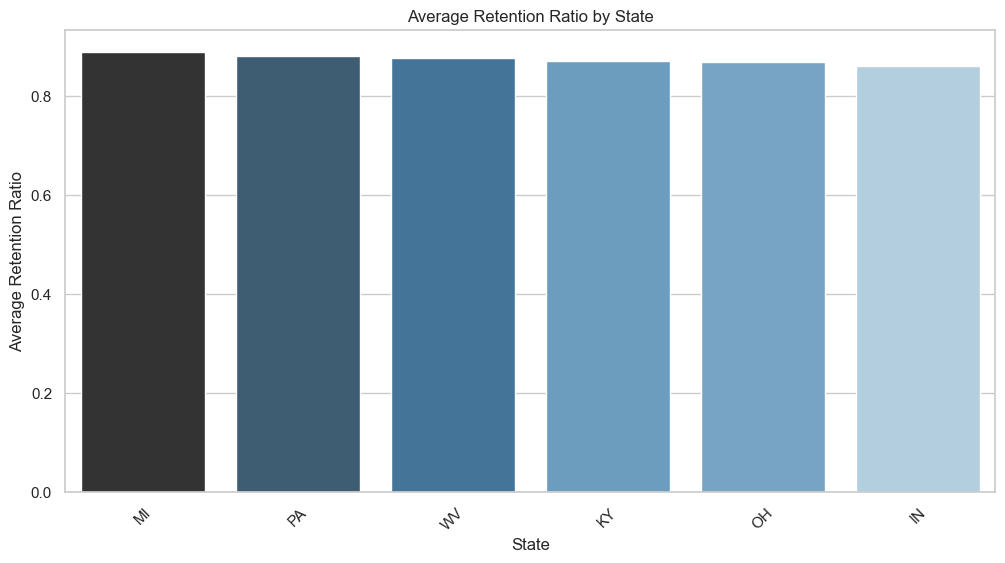

In [ ]:
#--- Grouped Analysis by State or Product ---
if 'STATE_ABBR' in df.columns:
    state_summary = df.groupby('STATE_ABBR')[['RETENTION_RATIO', 'LOSS_RATIO', 'GROWTH_RATE_3YR']].mean().sort_values(by='RETENTION_RATIO', ascending=False).reset_index()
    print("\nAverage metrics by state:\n", state_summary)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=state_summary, x='STATE_ABBR', y='RETENTION_RATIO', palette='Blues_d', hue = 'RETENTION_RATIO', legend=False)
    plt.title("Average Retention Ratio by State")
    plt.xlabel("State")
    plt.ylabel("Average Retention Ratio")
    plt.xticks(rotation=45)
    plt.show()

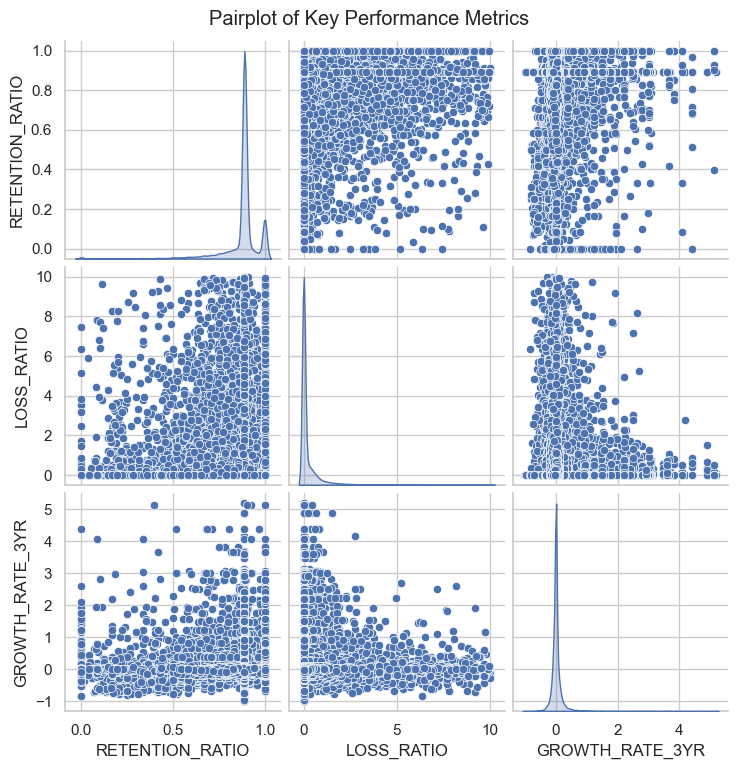

In [ ]:
# --- Pairplot for Selected Metrics ---
#Explore pairwise relationships among key performance indicators.
sns.pairplot(df, vars=['RETENTION_RATIO', 'LOSS_RATIO', 'GROWTH_RATE_3YR'], palette='Set2', diag_kind='kde')
plt.suptitle("Pairplot of Key Performance Metrics", y=1.02)
plt.show()

## Part 2: Feature Engineering

The features I selected were chosen to balance predictive power, business interpretability, and scalability across your full dataset. Here's the breakdown:

1. Retention & Loss Metrics <br>

    - `RETENTION_RATIO` - Captures loyalty—are agents retaining their business? <br>
    - `LOSS_RATIO`, `LOSS_RATIO_3YR` - Measures risk quality of the agent's book—higher = more costly claims. <br>
    - `GROWTH_RATE_3YR` - Indicates expansion—agents growing faster may be worth investing in or monitoring. <br><br>

2. Premium & Production Metrics <br>

    - `NB_WRTN_PREM_AMT`, `WRTN_PREM_AMT` - Total business written—core size/volume indicator. <br>
    - `PRD_ERND_PREM_AMT` - Ties to actual earnings—helps distinguish high-volume but low-profit agencies. <br><br>

3. Demographic & Structural Indicators <br>

    - `ACTIVE_PRODUCERS` - More producers usually mean broader reach or specialization. <br>
    - `PRODUCER_AGE_SPREAD` - Suggests diversity in workforce experience (senior vs junior mix). <br>
    - `AGENCY_TENURE` - Tied to maturity and embeddedness in their market. Longer tenure often = stability. <br><br>

4. Quote System Hit Ratios <br>

    - `HIT_RATIO_<__>` for each system (like eQT, SBZ, etc.) - These show how effectively agents convert quotes into bound policies. <br>
    - Analyzing by system gives insights into whether certain tech platforms drive better performance or indicate tech-savviness. <br><br>


These collectively give a 360° view of an agent’s performance:

- Retention and risk quality
- New business generation
- Efficiency in sales pipeline
- Demographic indicators of stability and capacity


In [13]:
#Drop irrelevant columns
df_clean = df.drop(columns=["Unnamed: 0"], errors='ignore')

#Quote system bound/quote pairs
quote_systems = [
    ("CL_BOUND_CT_MDS", "CL_QUO_CT_MDS"),
    ("CL_BOUND_CT_SBZ", "CL_QUO_CT_SBZ"),
    ("CL_BOUND_CT_eQT", "CL_QUO_CT_eQT"),
    ("PL_BOUND_CT_ELINKS", "PL_QUO_CT_ELINKS"),
    ("PL_BOUND_CT_PLRANK", "PL_QUO_CT_PLRANK"),
    ("PL_BOUND_CT_eQTte", "PL_QUO_CT_eQTte"),
    ("PL_BOUND_CT_APPLIED", "PL_QUO_CT_APPLIED"),
    ("PL_BOUND_CT_TRANSACTNOW", "PL_QUO_CT_TRANSACTNOW")
]

#Calculate hit ratios
for bound_col, quote_col in quote_systems:
    hit_ratio_col = f"HIT_RATIO_{bound_col.split('_')[2]}"
    df_clean[hit_ratio_col] = df_clean[bound_col] / df_clean[quote_col].replace(0, 1)

#Additional features
df_clean["PRODUCER_AGE_SPREAD"] = df_clean["MAX_AGE"] - df_clean["MIN_AGE"]
df_clean["AGENCY_TENURE"] = df_clean["STAT_PROFILE_DATE_YEAR"] - df_clean["AGENCY_APPOINTMENT_YEAR"]

#Sort and group by agency and year
df_sorted = df_clean.sort_values(by = ["AGENCY_ID", "STAT_PROFILE_DATE_YEAR"])

#List of numeric columns to compute YoY deltas on
cols_to_delta = [
    "WRTN_PREM_AMT", "RETENTION_RATIO", "LOSS_RATIO", 
    "NB_WRTN_PREM_AMT", "PRD_ERND_PREM_AMT"
]

#Compute YoY deltas
for col in cols_to_delta:
    delta_col = f"{col}_YOY_DELTA"
    df_sorted[delta_col] = df_sorted.groupby("AGENCY_ID")[col].diff()

#Replace NaNs from first-year differences with 0 or drop them if appropriate
df_sorted = df_sorted.fillna(0)

# Part 3: K-Means Clustering for Agent Segmentation

In [14]:
#Select features for clustering
feature_cols = [
    "RETENTION_RATIO", "LOSS_RATIO", "LOSS_RATIO_3YR", "GROWTH_RATE_3YR",
    "NB_WRTN_PREM_AMT", "WRTN_PREM_AMT", "PRD_ERND_PREM_AMT",
    "ACTIVE_PRODUCERS", "PRODUCER_AGE_SPREAD", "AGENCY_TENURE"
] + [f"HIT_RATIO_{bound_col.split('_')[2]}" for bound_col, _ in quote_systems]

delta_features = [f"{col}_YOY_DELTA" for col in cols_to_delta] #group together YoY delta features

all_features = feature_cols + delta_features #organize to get all feature cols together

features_df = df_sorted[all_features].fillna(0) 


scaler = StandardScaler() #standardize columns where there's a huge range so model isn't thrown off, e.g. WRTN_PREM_AMT which is 0-1,000,000
X_scaled = scaler.fit_transform(features_df) 


#Automatic K selection
silhouette_scores = []
K_range = range(2, 10)

#Loop with progress bar
for k in tqdm(K_range, desc="Evaluating KMeans"):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

best_k = K_range[np.argmax(silhouette_scores)]
print(f"Best number of clusters by silhouette score: {best_k}")


#Final clustering
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
df_sorted["AGENT_CLUSTER"] = kmeans_final.fit_predict(X_scaled)

"""
old method
silhouette_scores = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

best_k = K_range[np.argmax(silhouette_scores)]
print(f"Best number of clusters by silhouette score: {best_k}")
"""


Evaluating KMeans: 100%|██████████| 8/8 [28:20<00:00, 212.53s/it]

Best number of clusters by silhouette score: 2


'\nold method\nsilhouette_scores = []\nK_range = range(2, 10)\nfor k in K_range:\n    kmeans = KMeans(n_clusters=k, random_state=42)\n    labels = kmeans.fit_predict(X_scaled)\n    score = silhouette_score(X_scaled, labels)\n    silhouette_scores.append(score)\n\nbest_k = K_range[np.argmax(silhouette_scores)]\nprint(f"Best number of clusters by silhouette score: {best_k}")\n'

### Evaluation of K-Means VS. DBSCAN - Which is Better for Segmenting Our Agents?

In [15]:
"""
DBSCAN below, which will find clusters and noise points.

DBSCAN may find significantly more clusters than K-Means, 
in which case, DBSCAN clusters may be used as subcategories 
depending on the results of the evaluation
"""

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

#Run DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

#Add to dataframe
df_sorted["AGENT_CLUSTER_DBSCAN"] = labels

#Check number of clusters (excluding noise)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"DBSCAN found {n_clusters} clusters and {sum(labels == -1)} noise points.")

DBSCAN found 324 clusters and 30682 noise points.


In [16]:
def evaluate_clustering(X_scaled, labels, method_name=""):
    #Remove noise points for metrics if using DBSCAN
    valid_mask = labels != -1
    if valid_mask.sum() == 0:
        print(f"{method_name}: No valid clusters found.")
        return
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    silhouette = silhouette_score(X_scaled[valid_mask], labels[valid_mask])
    davies_bouldin = davies_bouldin_score(X_scaled[valid_mask], labels[valid_mask])
    noise_pct = 100 * (labels == -1).sum() / len(labels)

    print(f"=== {method_name} ===")
    print(f"Clusters Found: {n_clusters}")
    print(f"Silhouette Score: {silhouette:.3f} (higher is better)")
    print(f"Davies-Bouldin Score: {davies_bouldin:.3f} (lower is better)")
    print(f"Noise Points: {noise_pct:.1f}%")
    print()
    

evaluate_clustering(X_scaled, df_sorted["AGENT_CLUSTER"].values, method_name="K-Means")
evaluate_clustering(X_scaled, df_sorted["AGENT_CLUSTER_DBSCAN"].values, method_name="DBSCAN")

=== K-Means ===
Clusters Found: 2
Silhouette Score: 0.864 (higher is better)
Davies-Bouldin Score: 0.434 (lower is better)
Noise Points: 0.0%

=== DBSCAN ===
Clusters Found: 324
Silhouette Score: -0.271 (higher is better)
Davies-Bouldin Score: 0.759 (lower is better)
Noise Points: 25.0%



### Visualize Clusters with PCA

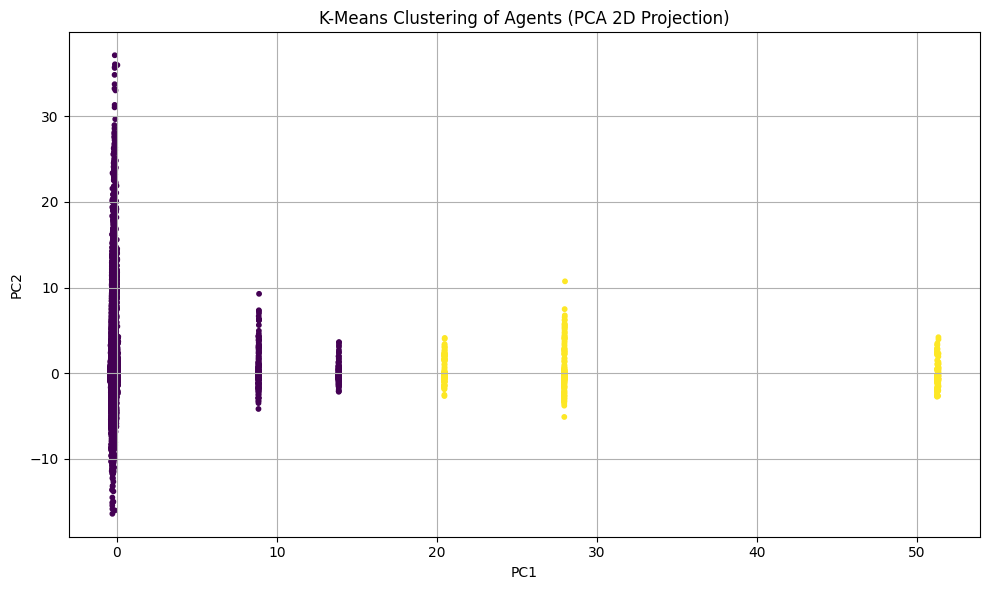

In [17]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_sorted["AGENT_CLUSTER"], cmap='viridis', s=10)
plt.title("K-Means Clustering of Agents (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
df_sorted.groupby("AGENT_CLUSTER")[["RETENTION_RATIO", "WRTN_PREM_AMT", "LOSS_RATIO", "GROWTH_RATE_3YR"]].mean()


,RETENTION_RATIO,WRTN_PREM_AMT,LOSS_RATIO,GROWTH_RATE_3YR
AGENT_CLUSTER,,,,
0,0.871650,28583.295042,0.286911,0.023081
1,0.873269,35594.620340,0.187796,0.052142


<Axes: xlabel='WRTN_PREM_AMT', ylabel='Density'>

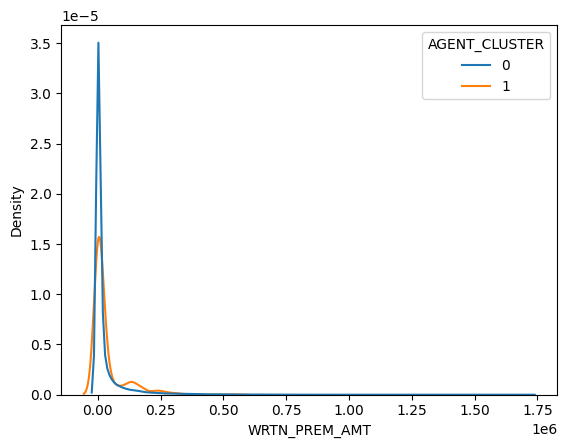

In [19]:
sns.kdeplot(data=df_sorted, x="WRTN_PREM_AMT", hue="AGENT_CLUSTER", common_norm=False)

Based on these findings, we can say that <br>

- Cluster 0 has lower Retention Ratio, lower Written Premium Amount, higher Loss Ratio, and a significantly lower 3-year Growth Rate

- Cluster 1 has higher Retention Ratio, higher Written Premium Amount, lower Loss Ratio, and a higher 3-year Growth Rate <br>

Given these average metrics, it is reasonable to interpret Cluster 0 as the relatively lower-performing group and Cluster 1 as the relatively higher-performing group. <br>

As a next step, we will use a Random Forest classifier to predict which agencies are at risk of under-performing based on their agents' performance.


# Part 4: Supervised Model to Predict Agencies' Risk of Low Performance 

<b> Target Variable: </b>
An agency is considered at-risk if it is in (or expected to shift to) the low-performing group (Cluster 0) in the future.

<b> Prediction Horizon: </b>
For example, predict whether an agency that is not underperforming today will become a low performer (Cluster 0) next year.

In [20]:
#Sort the DataFrame by agency and year
df_risk = df_sorted.sort_values(by=['AGENCY_ID', 'STAT_PROFILE_DATE_YEAR'])

#Create a column 'TARGET' that represents the cluster assignment for the next period
df_risk['TARGET'] = df_risk.groupby('AGENCY_ID')['AGENT_CLUSTER'].shift(-1)

#Define AT_RISK for the future period. Here we assume that if an agency will be in Cluster 0 next period, it's at risk.
df_risk['AT_RISK'] = (df_risk['TARGET'] == 0).astype(int)

#Drop rows that don't have a next-period target (usually the last observation per agency)
df_risk = df_risk.dropna(subset=['AT_RISK'])

In [21]:
df_risk.head()

,AGENCY_ID,PRIMARY_AGENCY_ID,PROD_ABBR,PROD_LINE,STATE_ABBR,STAT_PROFILE_DATE_YEAR,RETENTION_POLY_QTY,POLY_INFORCE_QTY,PREV_POLY_INFORCE_QTY,NB_WRTN_PREM_AMT,...,AGENCY_TENURE,WRTN_PREM_AMT_YOY_DELTA,RETENTION_RATIO_YOY_DELTA,LOSS_RATIO_YOY_DELTA,NB_WRTN_PREM_AMT_YOY_DELTA,PRD_ERND_PREM_AMT_YOY_DELTA,AGENT_CLUSTER,AGENT_CLUSTER_DBSCAN,TARGET,AT_RISK
1,3,3.0,BOILERMACH,CL,IN,2006,0,0,0.0,151.0,...,49.0,0.00,0.0,0.000000,0.0,0.00,0,0,0.0,1
12,3,3.0,BOILERMACH,CL,KY,2006,0,0,0.0,0.0,...,49.0,-6104.24,0.0,0.000000,-151.0,-5968.94,0,0,0.0,1
23,3,3.0,BOP,CL,IN,2006,0,0,0.0,0.0,...,49.0,23743.72,0.0,0.761985,0.0,24188.97,0,0,0.0,1
34,3,3.0,BOP,CL,KY,2006,0,0,0.0,0.0,...,49.0,-20920.32,0.0,-0.192379,0.0,-21199.32,0,0,0.0,1
45,3,3.0,COMMAUTO,CL,IN,2006,0,0,0.0,2817.0,...,49.0,361125.20,0.0,0.559576,2817.0,375966.46,0,-1,0.0,1


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.34      0.50       388
           1       0.99      1.00      0.99     24205

    accuracy                           0.99     24593
   macro avg       0.99      0.67      0.75     24593
weighted avg       0.99      0.99      0.99     24593

Confusion Matrix:
 [[  130   258]
 [    2 24203]]
ROC AUC Score: 0.8721999799819837


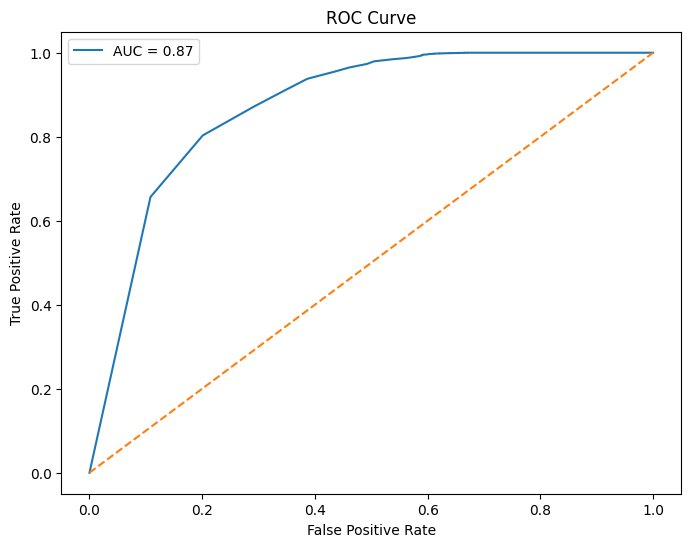

5-fold CV ROC AUC scores: [0.87725272 0.87138579 0.89268234 0.89026852 0.88345743]
Mean ROC AUC: 0.8830093587721427


In [22]:
#Data Preparation

features = [
    'RETENTION_RATIO',
    'LOSS_RATIO',
    'LOSS_RATIO_3YR',
    'GROWTH_RATE_3YR',
    'NB_WRTN_PREM_AMT',
    'WRTN_PREM_AMT',
    'PRD_ERND_PREM_AMT',
    'ACTIVE_PRODUCERS',
    'PRODUCER_AGE_SPREAD',
    'AGENCY_TENURE',
    'HIT_RATIO_CT',  # Ensure only one instance of HIT_RATIO_CT
    'WRTN_PREM_AMT_YOY_DELTA',
    'RETENTION_RATIO_YOY_DELTA',
    'LOSS_RATIO_YOY_DELTA',
    'NB_WRTN_PREM_AMT_YOY_DELTA',
    'PRD_ERND_PREM_AMT_YOY_DELTA'
]



# Double-check if there are any missing values in our features or target
df_risk = df_risk.dropna(subset=features + ['AT_RISK'])

#Define predictors and target
X = df_risk[features]
y = df_risk['AT_RISK']

# Split into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#Train a Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

#Evaluate the Model
y_pred = rf_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


y_prob = rf_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()

# Optionally use cross-validation for a robust performance measure
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='roc_auc')
print("5-fold CV ROC AUC scores:", cv_scores)
print("Mean ROC AUC:", np.mean(cv_scores))

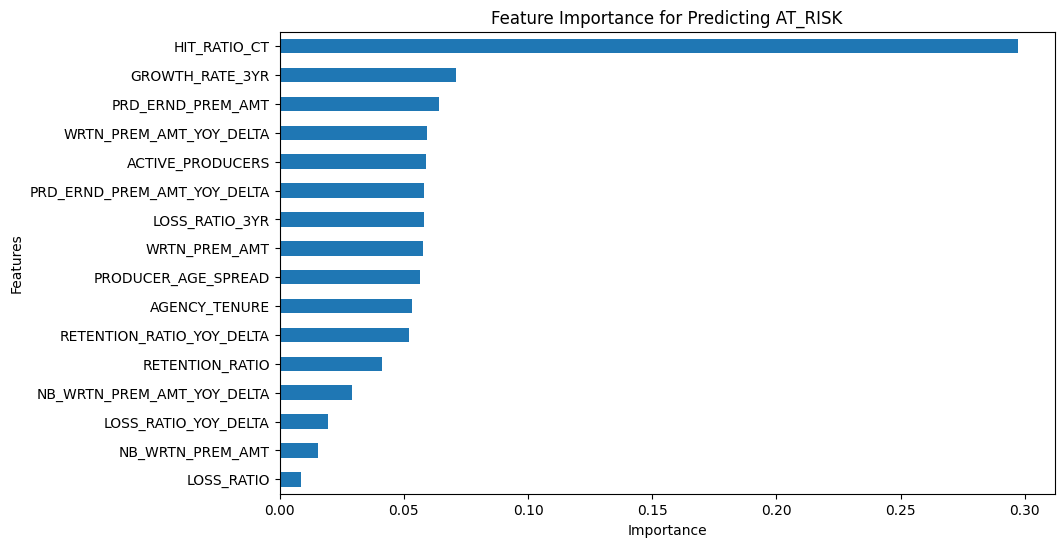

In [23]:
#Obtain built-in feature importances from the Random Forest
importances = rf_model.feature_importances_
feat_importance = pd.Series(importances, index=features).sort_values()

#Plot a bar chart of feature importances
plt.figure(figsize=(10, 6))
feat_importance.plot(kind='barh')
plt.title("Feature Importance for Predicting AT_RISK")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

### Export Results

In [24]:
df_risk.to_csv(r"C:\Users\maxwell.bicking\data-science-portfolio\Insurance Agent Classification\insurance_agents_clustered.csv", index=False)

# Conclusions

## Summary of Key Findings

1. **Data Profiling and EDA Insights:**
   - **Data Quality & Structure:**  
     A thorough exploratory data analysis (EDA) of the raw insurance agency data revealed a broad set of features—from demographic details (e.g., `AGENCY_ID`, `STATE_ABBR`) to performance metrics (e.g., `RETENTION_RATIO`, `LOSS_RATIO`, `GROWTH_RATE_3YR`) and operational dates (e.g., `AGENT_APPOINTMENT_YEAR`, `PL_START_YEAR`). This detailed examination of missing values, distributions, and correlations ensured the dataset was well understood before modeling.
   - **Key Performance Metrics:**  
     Visualizations (histograms, boxplots, and pairplots) highlighted that metrics such as retention ratios and loss ratios exhibit distinct patterns, suggesting they are critical in driving agency performance. Outlier detection further informed data cleaning and feature engineering steps.

2. **Clustering and Segmentation:**
   - **K-Means Clustering Outcome:**  
     The K-Means clustering segmented agencies into two distinct clusters. Detailed profiling and comparative visualization of cluster averages provided strong evidence that:
     - **Cluster 0:** Represents low-performing agencies, characterized by lower retention ratios, reduced written premium amounts, and higher loss ratios.
     - **Cluster 1:** Represents high-performing agencies, demonstrating higher retention ratios, increased premiums, and favorable growth rates.
   - **Interpretability & Validation:**  
     By comparing average performance metrics, the clustering effectively captured meaningful differences, forming actionable segments for further analysis and business interventions.

3. **Predictive Modeling – The Random Forest Classifier:**
   - **Model Performance:**  
     A supervised learning model was built upon the clustering results to predict the risk of underperformance. The Random Forest classifier achieved extremely high accuracy and precision:
     - **Accuracy:** Near-perfect overall accuracy, showcasing the model’s ability to correctly classify agencies.
     - **Class Imbalance Insight:** While predictions for high-performing agencies (Cluster 1) were very precise, the recall for identifying low-performing (at-risk) agencies was comparatively modest. This points to the need for threshold tuning or sampling adjustments to better capture the underperforming segment.
     
4. **Visualizations and Dashboard Potential:**
   - The exploratory visualizations not only confirmed the data quality and effectiveness of the clustering but also laid the foundation for an interactive Power BI dashboard. The dashboard is envisaged to display KPIs, trend analyses, and detailed segmentation views, enabling stakeholders to monitor agency performance in real time.

## Business Recommendations

1. **Targeted Interventions:**
   - **Resource Reallocation:**  
     Agencies identified as low-performing (Cluster 0) should be prioritized for additional support, such as enhanced training programs or revised incentive structures.
   - **Performance Monitoring:**  
     Implement an interactive dashboard to continuously monitor at-risk agencies, enabling proactive interventions before performance deteriorates further.

2. **Refinements Based on Predictive Insights:**
   - **Threshold and Recall Optimization:**  
     Given the model’s high precision but lower recall for underperformers, consider optimizing classification thresholds and exploring cost-sensitive approaches to reduce false negatives.
   - **Integration of Temporal Data:**  
     Extend the predictive framework by incorporating temporal trends to build a more robust future performance forecast.

3. **Strategic Decision-Making:**
   - **Dashboard-Driven Strategies:**  
     Utilize a Power BI dashboard to provide real-time insights into key performance metrics segmented by cluster, thereby enabling informed, data-driven decisions.
   - **Continuous Improvement:**  
     Regularly update and retrain the models with new data, ensuring the system adapts to evolving market conditions and agency behavior.

## Next Steps

- **Model Refinement and Tuning:**
  - **Hyperparameter Optimization:**  
    Explore further fine-tuning of model parameters (e.g., adjusting tree depth, number of estimators, or sample weights) to improve the recall of underperforming agencies. Experimenting with additional trials may help identify an optimal configuration.
  - **Cross-Validation and Threshold Adjustment:**  
    Implement robust cross-validation techniques to ensure the model generalizes well to unseen data. Evaluate different decision thresholds to balance precision and recall in a manner that aligns with business priorities.

- **Data Enhancement and Feature Engineering:**
  - **Temporal Analysis:**  
    Integrate additional time-dependent features or lagged variables to capture performance trends over time.
  - **External Data Integration:**  
    Consider incorporating external factors (e.g., economic indicators, regional events) that might affect agency performance, to further enrich the model.

- **Deployment and Monitoring:**
  - **Dashboard Integration:**  
    Develop a Power BI dashboard that integrates the predictive outputs with real-time data feeds. This will empower stakeholders to monitor key KPIs and receive alerts for agencies at risk.
  - **Continuous Feedback Loop:**  
    Establish a monitoring system to continually evaluate model performance against actual outcomes, enabling regular updates and improvements.

- **Scaling the Approach:**
  - Expand the use of this analytical framework to other segments or product lines within the business, leveraging the successes of this project as a blueprint for further predictive analytics initiatives.

## Project Successes and Impact

- **End-to-End Data Science Pipeline:**  
  The project successfully demonstrated a full data science workflow—from data ingestion and cleaning to clustering, predictive modeling, and visualization. 
- **Actionable Business Intelligence:**  
  The segmentation and predictive models provide clear and actionable insights that enable targeted interventions, potentially improving agency performance and reducing revenue loss.
- **Scalability and Adaptability:**  
  By using established methods such as K-Means and Random Forest classification, combined with advanced visualization techniques, the approach is both scalable and adaptable for future enhancements and additional analytical challenges.

---

In summary, this project effectively leverages data science techniques to uncover and address key performance drivers in the insurance agency domain. The insights obtained support proactive business interventions, while the planned dashboard integration will ensure continuous, real-time monitoring and strategic decision-making. 